In [40]:
from __future__ import (absolute_import, print_function, unicode_literals,
                        division)

import logging
logging.basicConfig(level=logging.DEBUG)
import time

from matplotlib.ticker import FuncFormatter
import base_node
import dropbot as db
import dropbot.chip
import hv_switching_board as hv
import joblib
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.ticker
import numpy as np
import pandas as pd
import si_prefix as si
import si_prefix as si

from contextlib import closing

%matplotlib inline

F_formatter = mpl.ticker.FuncFormatter(lambda x, *args: si.si_format(x) + 'F')

# Open DropBot connection

In [41]:
import base_node_rpc as bnr
import base_node_rpc.proxy

try:
    proxy.terminate()
except:
    pass
proxy = db.SerialProxy(ignore=[bnr.proxy.DeviceVersionMismatch])

proxy.enable_events()

proxy.update_state(hv_output_enabled=True, hv_output_selected=True,
                   voltage=50, frequency=10e3)

# Disable channels in contact with copper tape.
# disabled_channels_mask_i = proxy.disabled_channels_mask
# disabled_channels_mask_i[[89, 30]] = 1
# proxy.disabled_channels_mask = disabled_channels_mask_i

DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.async:`ProactorEventLoop` required, not `<class 'trollius.windows_events._WindowsSelectorEventLoop'>`loop in background thread.
DEBUG:base_node_rpc.async:Execute new loop in background thread.
DEBUG:trollius:Using proactor: IocpProactor
DEBUG:base_node_rpc.proxy:Attempt to connect to device on port COM15 (baudrate=115200)
DEBUG:serial_device.threaded:Open `COM15` and monitor connection status
DEBUG:serial_device.threaded:connection_made: `COM15` `<ReaderThread(Thread-28, started daemon 16092)>`
DEBUG:base_node_rpc.proxy:Wait for connection to port COM15
INFO:base_node_rpc.proxy:Successfully connected to dropbot on port COM15


1

In [42]:
CMD_GET_GENERAL_CALL_ENABLED = 0xA5
CMD_GET_SENSITIVE_CHANNELS = 0xAA
CMD_GET_SWITCHING_MATRIX_ROW = 0xA7
CMD_RAM_FREE = 0xA8
CMD_REBOOT = 0xA2
CMD_RESET_CONFIG = 0xA3
CMD_SET_GENERAL_CALL_ENABLED = 0xA4
CMD_SET_SENSITIVE_CHANNELS = 0xA9
CMD_SET_SWITCHING_MATRIX_ROW = 0xA6
PCA9505_CONFIG_IO_REGISTER_ = 0x18
PCA9505_OUTPUT_PORT_REGISTER_ = 0x08
CMD_GET_SENSITIVE_OFFSET = 0xAB

CMD_GET_CHANNEL_DUTY_CYCLE = 0xAC
CMD_SET_CHANNEL_DUTY_CYCLE = 0xAD

In [43]:
from contextlib import closing

import numpy as np
import pandas as pd
import visa
logging.getLogger('pyvisa').setLevel(logging.CRITICAL)


def read_voltages():
    # See http://beyondmeasure.rigoltech.com/acton/attachment/1579/f-0012/0/-/-/-/-/file.pdf
    rm = visa.ResourceManager()

    res = rm.list_resources()

    with closing(rm.get_instrument(res[0], open_timeout=20000)) as ins:
        ins.timeout = 45000
        fields = ['manufacturer', 'device', 'serial number', 'firmware version']
        property_map = {'device': ('*IDN?', lambda x: dict(zip(fields, x.split(',')))),
                        'voltage_scale': (':CHAN1:SCAL?', float),
                        'probe': (':CHAN1:PROB?', float),
                        'sampling_rate': (':ACQ:SAMP? CHAN1', float),
                        'time_scale': (':TIM:SCAL?', float)}

        properties = {k: v[1](ins.query(v[0]))
                      for k, v in property_map.items()}
        ins.write(':WAV:DATA? CHAN1')
        data = ins.read_raw()
        ins.write(':KEY:FORC')

    header_length = int(data[1])
    byte_count = int(data[2:2 + header_length])

    voltages = (properties['voltage_scale'] * properties['probe'] *
                pd.Series((np.frombuffer(data[header_length + 2:header_length + 2 + byte_count],
                                         dtype='uint16') / ((1 << 16) - 1) - .5) * -1))
    voltages.index /= properties['sampling_rate']
    voltages.name = 'voltage (V)'
    voltages.index.name = 'time (s)'
    return voltages

In [44]:
def i2c_read_response(self, address):
    n = self.i2c_read(address, 1)
    return self.i2c_read(address, n)


def set_sensitive_channels(self, channels):
    # Set every 7th channel as sensitive.
    states = np.zeros(self.number_of_channels, dtype='bool')
    states[channels] = 1
    # Bit-pack list of sensitive channels as binary byte array.
    packed_channels = np.packbits(states[::-1])[::-1]
    self.i2c_write(0, [CMD_SET_SENSITIVE_CHANNELS] + packed_channels.tolist())


def get_sensitive_channels(self):
    cmd = CMD_GET_SENSITIVE_CHANNELS
    # Broadcast sensitive channels request to all switching boards.
    self.i2c_write(0, [cmd])
    # Read response from each board individually.
    board_responses = [i2c_read_response(self, 32 + board_id)[:5]
                       for board_id in range(3)]
    global_sensitive_mask = \
        np.unpackbits(np.concatenate(board_responses)[::-1])[::-1]
    if max(global_sensitive_mask) < 1:
        return np.array([])
    else:
        return np.where(global_sensitive_mask)[0]
    
def get_sensitive_offsets(self):
    cmd = CMD_GET_SENSITIVE_OFFSET
    self.i2c_write(0, [cmd])

    return [i2c_read_response(self, 32 + board_id)[0]
            for board_id in range(3)]


def set_duty_cycle(self, duty_cycle, channels):
    # Process channels in chunks to avoid overflowing maximum I2C message length.
    chunks_count = int(np.ceil(len(channels) / 22.))
    cmd = CMD_SET_CHANNEL_DUTY_CYCLE
    for channels_i in np.array_split(channels, chunks_count):
        data = np.array([duty_cycle], dtype='float32').view('uint8').tolist()
        self.i2c_write(0, [cmd] + data + channels_i.tolist())
        

def get_duty_cycle(self, channel):
    cmd = CMD_GET_CHANNEL_DUTY_CYCLE
    self.i2c_write(0, [cmd, channel])

    for board_id in range(3):
        response = i2c_read_response(self, 32 + board_id)
        if len(response) > 1:
            return np.array(response[:4], dtype='uint8').view('float32')[0]
        
        
def set_switching_matrix_row(self, matrix_row_i, row_count):
    self.i2c_write(0, [CMD_SET_SWITCHING_MATRIX_ROW, matrix_row_i, row_count])

In [45]:
def measure_channel_switching_waveform(proxy, matrix_rows=None,
                                       settling_s=.25, periods=2, ):
    '''
    Cycle through the switching matrix, and measure the resulting waveform
    from a connected RIGOL DS1102E oscilloscope.
    
    Parameters
    ----------
    proxy : dropbot.SerialProxy
    matrix_rows : int, optional
        Number of rows in the switching matrix _(default: number of sensitive
        channels)_.
    settling_s : float, optional
        Number of seconds to wait for oscilloscope to settle after sending RUN
        command.
    periods : int, optional
        Number of periods to cyle through the switching matrix.
    '''
    if matrix_rows is None:
        sensitive_channels = get_sensitive_channels(proxy)
        matrix_rows = len(sensitive_channels)
        
    # See http://beyondmeasure.rigoltech.com/acton/attachment/1579/f-0012/0/-/-/-/-/file.pdf
    resource_manager = visa.ResourceManager()
    resources = resource_manager.list_resources()
    
    # Request oscilloscope to run.
    with closing(resource_manager.get_instrument(resources[0], open_timeout=20000)) as inst:
        inst.write(':RUN')
        inst.write(':KEY:FORC')
    # Wait for oscilloscope state to settle.
    time.sleep(settling_s)

    for i in range(periods):
        for row in range(matrix_rows):
            set_switching_matrix_row(proxy, row, matrix_rows)
            
    # Turn off all channels.
    proxy.state_of_channels = np.zeros(proxy.number_of_channels)
    return read_voltages()

# Example: 10 sensitive channels with duty cycles ranging from 0-100%

## Set up

 1. Insert test board into DropBot.
 2. Connect DropBot.
 3. Connect RIGOL DS1102E USB cable.
 5. Run code cells below.
 6. When presented with a prompt, touch the oscilloscope to channels 0-9, one at a time, in order.
   - For example, for channel 0:
   ![image.jpg](images/dev%28broadcast-i2c%29/measure-channel-0.jpg)
   - For example, for channel 9:
   ![image.jpg](images/dev%28broadcast-i2c%29/measure-channel-9.jpg)
 
## Example output

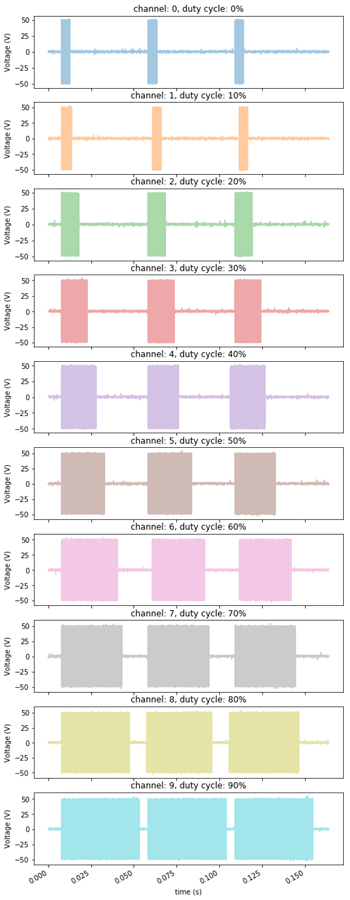

In [46]:
set_sensitive_channels(proxy, range(10))
sensitive_channels = get_sensitive_channels(proxy)
sensitive_channels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [50]:
proxy.sensitive_channels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
proxy.sensitive_channels = range(10, 20, 2)
proxy.sensitive_channels

array([10, 12, 14, 16, 18])

In [35]:
set_sensitive_channels(proxy, range(10))
sensitive_channels = get_sensitive_channels(proxy)

for i, channel in enumerate(sensitive_channels):
    set_duty_cycle(proxy, float(i) / len(sensitive_channels), [channel])
    
duty_cycles = np.array([get_duty_cycle(proxy, channel)
                        for channel in sensitive_channels]).round(2)

display(sensitive_channels)
display(duty_cycles)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], dtype=float32)

In [ ]:
voltage_series = []
for channel, duty_cycle in zip(sensitive_channels, duty_cycles):
    raw_input()
    voltages = measure_channel_switching_waveform(proxy, settling_s=.5, periods=3)
    voltages.name = channel
    voltage_series.append(voltages)

In [ ]:
df_voltages = pd.DataFrame(voltage_series).T
axes = df_voltages.plot(alpha=.4, subplots=True, legend=False,
                        figsize=(8, 2.5 * len(sensitive_channels)))
for channel, duty_cycle, axis in zip(sensitive_channels, duty_cycles, axes):
    axis.set_title('channel: %s, duty cycle: %.0f%%' % (channel,
                                                        duty_cycle * 100))
    axis.set_ylabel('Voltage (V)')

In [ ]:
proxy.terminate()